In [9]:
import urllib
import re
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit as cf

def lin_func(x,m,c):
    y = m*x + c
    return y

def read_data(targ):
    ins = "wfc3-uvis-acs-wfc"
    filt = "multi"
    exteng = "1"

    url = "https://archive.stsci.edu/hlsps/hugs/ngc"+targ+"/hlsp_hugs_hst_"+ins+"_ngc"+targ+"_"+filt+"_v1_catalog-meth"+exteng+".txt"
    file = urllib.request.urlopen(url)  

    ptr = 1
    hd = []

    hd.append("Nan") 
    hd.append("X")  
    hd.append("Y")

    with open(r"D:\IIT material\Krittika python project\NGC"+targ+" data.txt", 'w') as f1, open(r"D:\IIT material\Krittika python project\NGC"+targ+" header.txt", 'w') as f2:
        for line in file:
            line = line.decode("utf-8")
            f2.write(line)
            if ptr > 54:    
                f1.write(re.sub('[\t ]+',' ', line))
            ptr += 1        

    with open(r"D:\IIT material\Krittika python project\NGC"+targ+" header.txt", 'r') as fr:
        lines = fr.readlines()

        for i in range(14, 50):
            hd.append(lines[i])

    file_path = r"D:\IIT material\Krittika python project\NGC"+targ+" data.txt"

    df = pd.read_csv(file_path, sep = ' ')

    df.columns = hd

    df.drop(['Nan'], inplace=True, axis=1)

    df.drop(df[df['# Col. 33: Membership Probability [-1.0: not available]\n'] < 90].index, inplace = True)
    df.drop(df[df['# Col.  3: F275W calibrated magnitude\n'] < 0].index, inplace = True)
    df.drop(df[df['# Col.  9: F336W calibrated magnitude\n'] < 0].index, inplace = True)
    df.drop(df[df['# Col. 15: F438W calibrated magnitude\n'] < 0].index, inplace = True)
    df.drop(df[df['# Col. 27: F814W calibrated magnitude\n'] < 0].index, inplace = True)
    df.drop(df[df['# Col. 21: F606W calibrated magnitude\n'] < 0].index, inplace = True)
    df['Color index'] = df['# Col.  9: F336W calibrated magnitude\n'] - df['# Col. 21: F606W calibrated magnitude\n']
    return df

In [10]:
def magcutter(df1, df2):
    #Setting a magnitude limit to just include the stars on the main sequence
    def maglimit(y,ep): # Takes the entire y as parameters   
        for i in range(y.size -1):          
            if i > 0 :
                d1 = abs(y[i] - y[i-1]) # Difference 1
                d2 = abs(y[i+1] - y[i]) # Difference 2
                if d1 <= ep and d2 <= ep and y[i] < y.median() : # Condition for constant y, must lie in upper half
                    return y[i] #The constant y

    e = 0.01
    ep = 0
    # Finding the limit, if none is returned increase the value of epsilon, and call again
    while True: 
        lim1 = maglimit(df1['# Col.  9: F336W calibrated magnitude\n'],ep)
        if type(lim1) == type(None):
            ep += e
        else:
            break

    ep = 0
    # Finding the limit, if none is returned increase the value of epsilon, and call again
    while True:
        lim2 = maglimit(df2['# Col.  9: F336W calibrated magnitude\n'],ep)
        if type(lim2) == type(None):
            ep += e
        else:
            break
            
    return lim1, lim2 

In [11]:
def main_seq(targ1, targ2):
    #reading the data
    df1 = read_data(targ1)
    df2 = read_data(targ2)
    #reindexing the dataframe
    df1.index = pd.RangeIndex(len(df1.index))
    df1.index = range(len(df1.index))
    df2.index = pd.RangeIndex(len(df2.index))
    df2.index = range(len(df2.index))
    
    lim1, lim2 = magcutter(df1, df2)
    
    #font style for the plot
    font = {'family': 'serif',
            'color':  'black',
            'weight': 'ultralight',
            'size': 20,
            }
    
    #Selecting the main sequence stars
    y1n = df1['# Col.  9: F336W calibrated magnitude\n'].to_numpy()
    x1n = df1['Color index'].to_numpy()
    Y1 = []
    X1 = []
    
    for i in range(len(y1n)):
        if y1n[i] > lim1:
            Y1.append(y1n[i])
            X1.append(x1n[i]) 
                
    y2n = df2['# Col.  9: F336W calibrated magnitude\n'].to_numpy()
    x2n = df2['Color index'].to_numpy()
    Y2 = []
    X2 = []
    
    for i in range(len(y2n)):
        if y2n[i] > lim2:
            Y2.append(y2n[i])
            X2.append(x2n[i]) 
    
    X1 = numpy.array(X1)
    X2 = numpy.array(X2)
    Y1 = numpy.array(Y1)
    Y2 = numpy.array(Y2)
    
    #line fit
    p_opt1, p_cov1 = cf(lin_func, X1, Y1)
    p_opt2, p_cov2 = cf(lin_func, X2, Y2)
    
    #making the lines parallel
    slope = (p_opt1[0] + p_opt2[0])/2
    
    x1 = df1['Color index']
    x2 = df2['Color index']
    y1 = df1['# Col.  9: F336W calibrated magnitude\n']
    y2 = df2['# Col.  9: F336W calibrated magnitude\n']
    xmin = min(x1.min(), x2.min())
    xmax = max(x1.max(), x2.max())
    ymin = min(y1.min(), y2.min())
    ymax = max(y1.max(), y2.max())
    
    X1 = X1[(X1 > xmin+2) & (X1 < xmax-4)]
    X2 = X2[(X2 > xmin+2) & (X2 < xmax-4)]   #hardcoded to make the plot look nice
    
    plt.figure(figsize = (15, 15))
    plt.plot(X1, lin_func(X1, slope, p_opt1[1]), color = 'blue')
    plt.plot(X2, lin_func(X2, slope, p_opt2[1]), color = 'green')
    plt.scatter(x1, y1, s = 0.005, color = 'black', label = targ1)  
    plt.scatter(x2, y2, s = 0.005, color = 'red', label = targ2)
    #plt.plot(x1,numpy.full(df1.shape[0],cut1),c = [0.5,0.5,0.5]) #To show the magnitude limit
    #plt.plot(x2,numpy.full(df2.shape[0],cut2),c = [0.5,0.5,0.5])
    plt.gca().invert_yaxis()
    plt.title("NGC"+targ1+" and NGC"+targ2, fontsize = 30, y = 1.01, fontdict = font)
    plt.xlabel(r'$m_{F336W} - m_{F606W}$', fontsize = 20, fontdict = font)
    plt.ylabel(r'$m_{F336W}$', fontsize = 20, fontdict = font)
    plt.xlim = (xmin, xmax)
    plt.ylim = (ymin, ymax)
    plt.tick_params(labelsize=15, pad = 6)
    plt.savefig("D:\IIT material\Krittika python project\main_seq.png")
    lgnd = plt.legend(scatterpoints=1, fontsize=10)
    lgnd.legendHandles[0]._sizes = [30]
    lgnd.legendHandles[1]._sizes = [30]
    plt.show()
    
    dist_mod = abs((p_opt1[1] - p_opt2[1]) / (1+ (slope)**2 )**0.5) 
    ratio = 10**(dist_mod/5)
    dist = ratio * 10.4
    
    print("Main Sequence Matching of clusters NGC"+targ1+" and NGC"+targ2)
    print("Distance Modulus = "+ str(dist_mod))
    print("Ratio = "+ str(ratio))
    print("Distance between the two clusters = "+ str(dist)+" kpc")

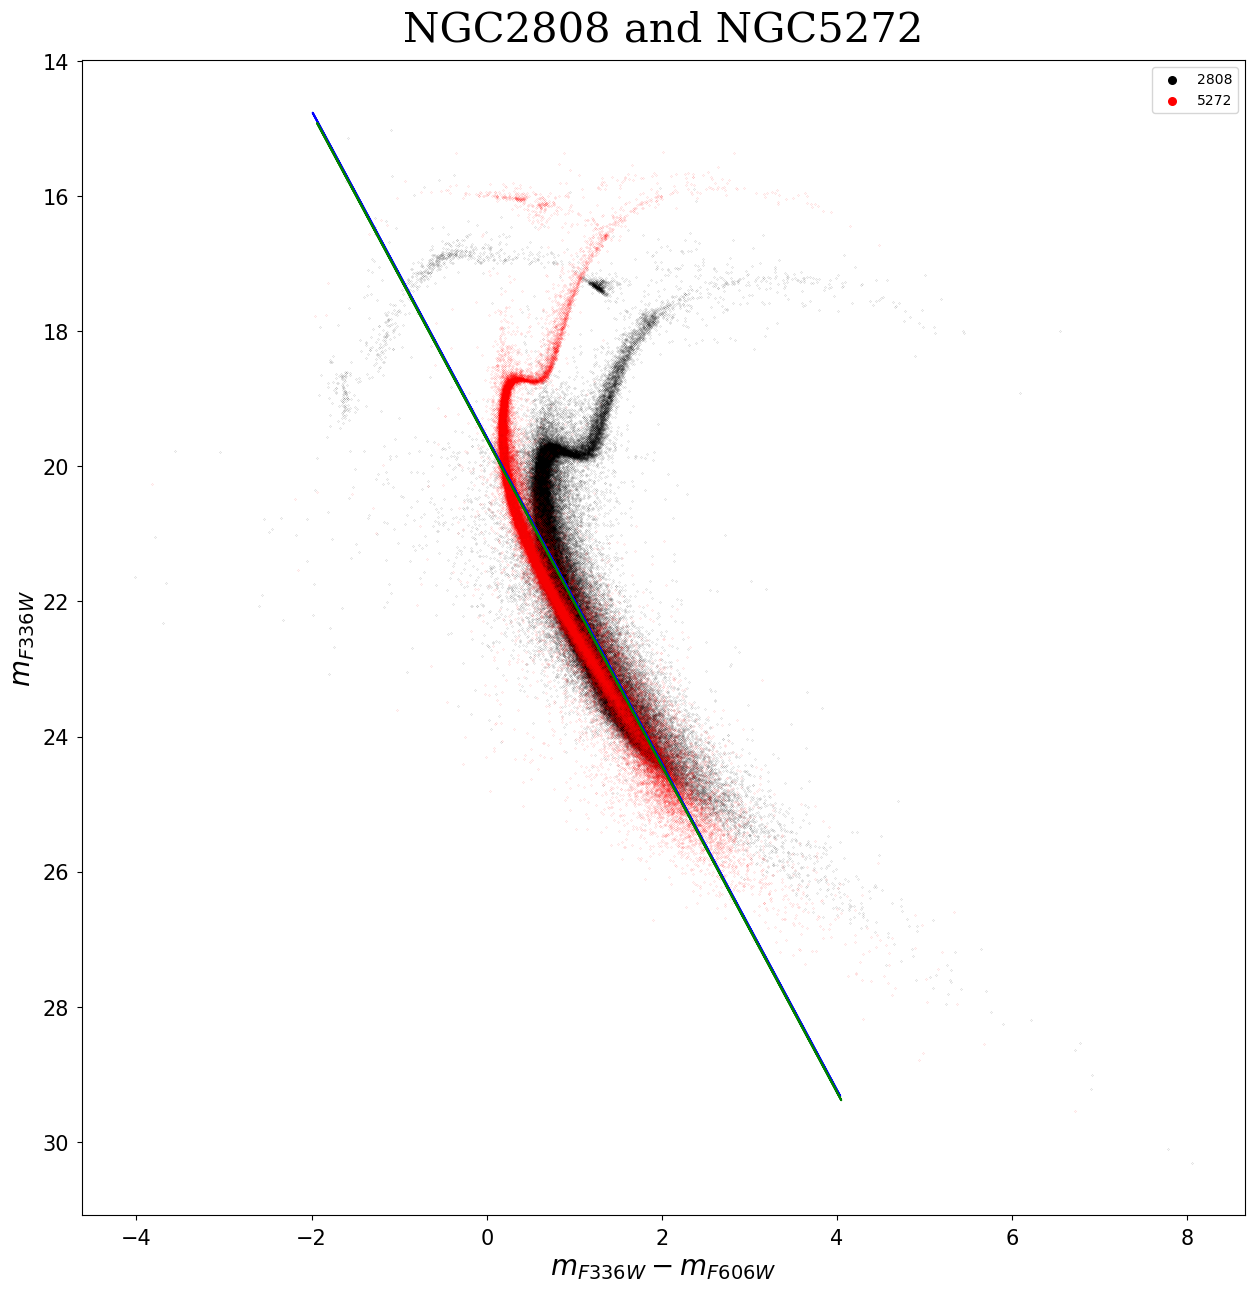

Main Sequence Matching of clusters NGC2808 and NGC5272
Distance Modulus = 0.012142367040561219
Ratio = 1.0056074297766944
Distance between the two clusters = 10.458317269677622 kpc


In [12]:
main_seq("2808", "5272")

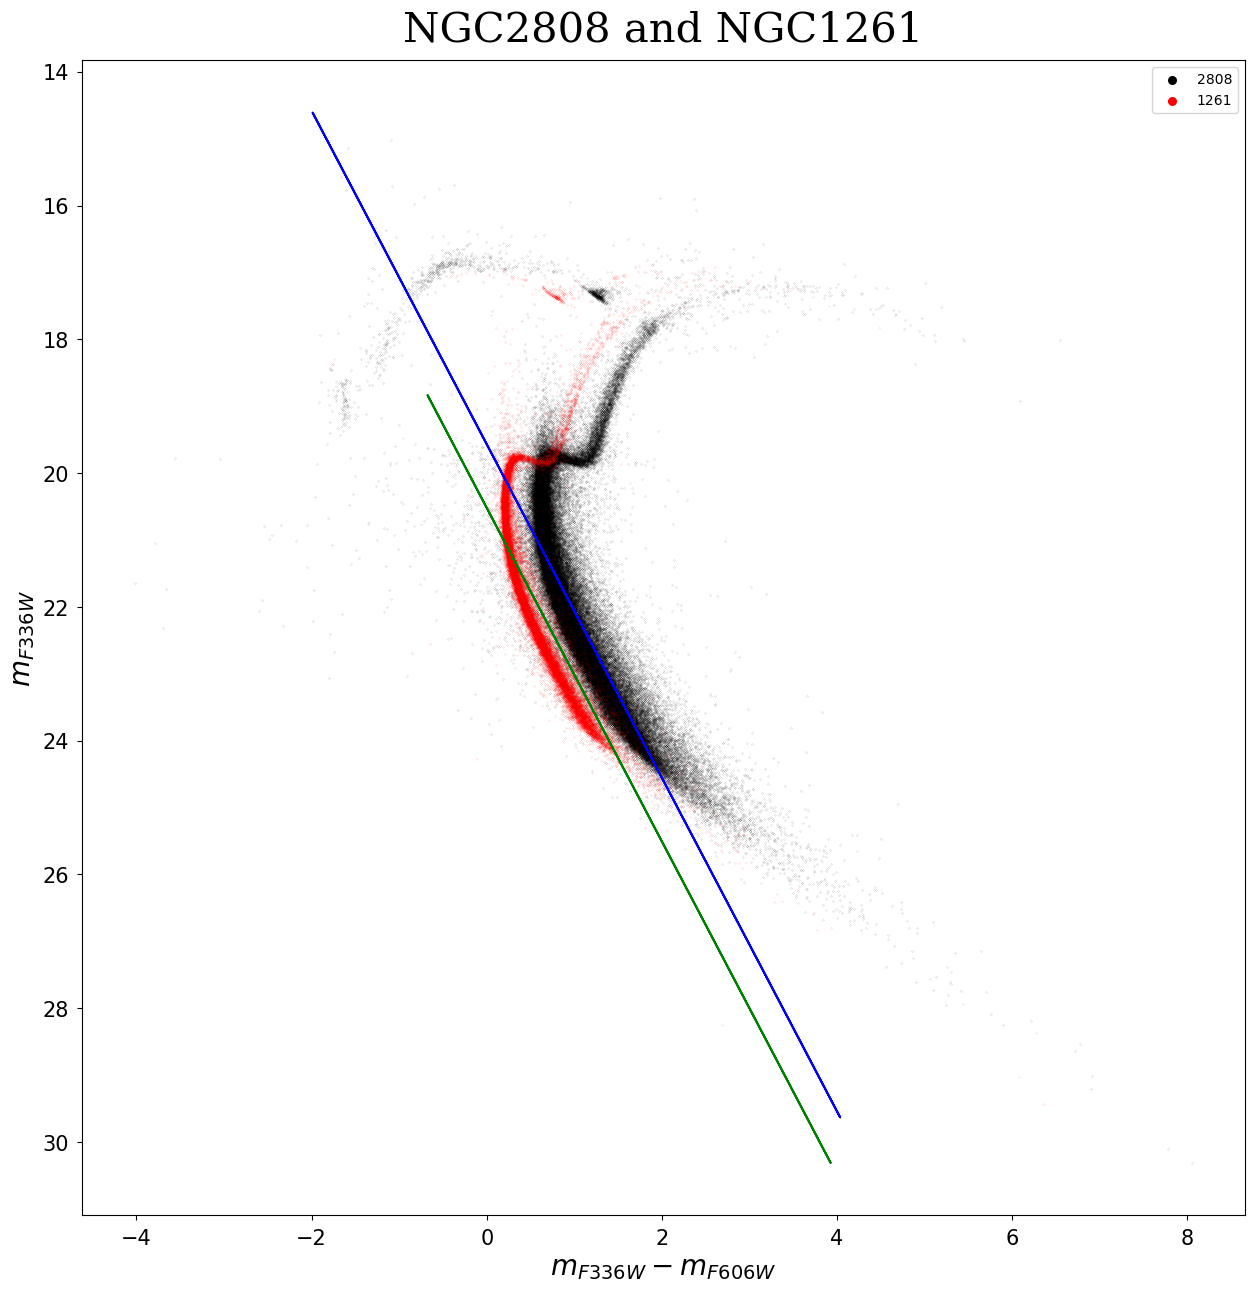

Main Sequence Matching of clusters NGC2808 and NGC1261
Distance Modulus = 0.35419462133712226
Ratio = 1.177169291543108
Distance between the two clusters = 12.242560632048324 kpc


In [13]:
main_seq("2808", "1261")